In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers, optimizers
import numpy as np
import matplotlib.pyplot as plt



(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std  = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean)/(std+1e-7)



170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
# Original VGG16 architecture, Batch Normalization added, DropOut added, He initializer added, Skip connection added
he_initializer = tf.keras.initializers.HeNormal()
inputs = tf.keras.layers.Input(shape=[32, 32, 3])    
x = inputs

# block 1
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

res = x

# block 2
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

# skip connection
res = tf.keras.layers.Conv2D(128, 1, strides = 2, padding = 'same')(res)
x = tf.keras.layers.concatenate([x, res], axis = -1)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

res = x

# block 3
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(256, 3, padding='same', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

res = tf.keras.layers.Conv2D(256, 1, strides = 2, padding = 'same')(res)
x = tf.keras.layers.concatenate([x, res], axis = -1)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

# block 4
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

res = tf.keras.layers.Conv2D(512, 1, strides = 2, padding = 'same')(res)
x = tf.keras.layers.concatenate([x, res], axis = -1)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

res = x

# block 5
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer = he_initializer)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

res = tf.keras.layers.Conv2D(512, 1, strides = 2, padding = 'same')(res)
x = tf.keras.layers.concatenate([x, res], axis = -1)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

# FC layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, kernel_initializer = he_initializer)(x)
x = tf.keras.layers.Dense(128, kernel_initializer = he_initializer)(x)
x = tf.keras.layers.Dense(10, activation = 'softmax')(x)


model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   36928       ['batch_normalization_3[0][0]

In [ ]:
#training with adam
batch_size = 256
epochs = 100
lr = 0.0005

opt_adam  = keras.optimizers.Adam(learning_rate=lr)

# data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def process_data(image, label):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.resize(image, (38, 38))
        image = tf.image.random_crop(image, size=[32, 32, 3])
        
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

    return image, label

train_batches = (train_dataset.shuffle(256*4)
                              .map(process_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(batch_size)
                              .prefetch(tf.data.experimental.AUTOTUNE) )

test_dataset = (test_dataset.batch(batch_size))


model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history = model.fit(train_batches, validation_data=test_dataset, epochs=epochs, verbose=1)

Epoch 1/100
196/196 [==============================] - 17s 34ms/step - loss: 2.2663 - accuracy: 0.3127 - val_loss: 1.7244 - val_accuracy: 0.3726
Epoch 2/100
196/196 [==============================] - 5s 26ms/step - loss: 1.5863 - accuracy: 0.4395 - val_loss: 2.3414 - val_accuracy: 0.3230
Epoch 3/100
196/196 [==============================] - 5s 25ms/step - loss: 1.3843 - accuracy: 0.5040 - val_loss: 2.6922 - val_accuracy: 0.3461
Epoch 4/100
196/196 [==============================] - 5s 25ms/step - loss: 1.2333 - accuracy: 0.5606 - val_loss: 2.0080 - val_accuracy: 0.4627
Epoch 5/100
196/196 [==============================] - 5s 24ms/step - loss: 1.1109 - accuracy: 0.6038 - val_loss: 1.8818 - val_accuracy: 0.4706
Epoch 6/100
196/196 [==============================] - 5s 24ms/step - loss: 1.0111 - accuracy: 0.6411 - val_loss: 1.5713 - val_accuracy: 0.5519
Epoch 7/100
196/196 [==============================] - 5s 25ms/step - loss: 0.9217 - accuracy: 0.6763 - val_loss: 1.2707 - val_accuracy

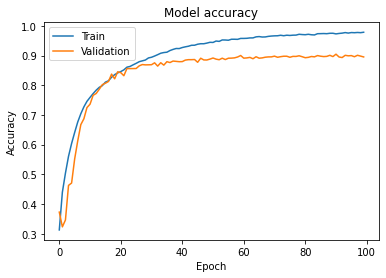

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

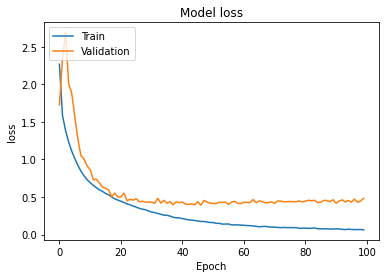

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()